# Loan Approval Prediction



**🔹 1. Import Required Libraries**

In [8]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


## 2. Load Dataset

In [23]:


data = pd.read_csv("loan_data.csv")


data.columns = [c.strip() for c in data.columns]

print("Columns:", list(data.columns))
print("Rows:", len(data))
print(data.head())


Columns: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']
Rows: 4269
   loan_id  no_of_dependents      education self_employed  income_annum  \
0        1                 2       Graduate            No       9600000   
1        2                 0   Not Graduate           Yes       4100000   
2        3                 3       Graduate            No       9100000   
3        4                 3       Graduate            No       8200000   
4        5                 5   Not Graduate           Yes       9800000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     29900000         12          778                   2400000   
1     12200000          8          417                   2700000   
2     29700000         20          506                   7100000   
3     30700000         

## 3. Fix Target Column (Approved / Rejected → 1 / 0)

In [3]:

target_candidates = [c for c in data.columns if 'status' in c.lower() or 'target' in c.lower() or 'label' in c.lower()]
print("Target candidates:", target_candidates)
assert len(target_candidates) > 0, "No target column found!"

target_col = target_candidates[0]
print("Using target column:", target_col)

print("Unique values BEFORE:", data[target_col].unique())

data[target_col] = data[target_col].astype(str).str.strip()

mapping = {
    'Approved': 1, 'Rejected': 0,
    'approved': 1, 'rejected': 0,
    'Y': 1, 'N': 0,
    'Yes': 1, 'No': 0,
    '1': 1, '0': 0
}

data[target_col] = data[target_col].map(mapping)

before = len(data)
data = data.dropna(subset=[target_col])
after = len(data)

print(f"Dropped {before-after} rows with invalid target")
print("Rows after cleaning:", len(data))

data[target_col] = data[target_col].astype(int)

print("Unique values AFTER:", data[target_col].unique())


Target candidates: ['loan_status']
Using target column: loan_status
Unique values BEFORE: [' Approved' ' Rejected']
Dropped 0 rows with invalid target
Rows after cleaning: 4269
Unique values AFTER: [1 0]


## 4. Fill Missing Values + Encode

In [4]:

for col in list(data.columns):
    if 'id' in col.lower():
        data = data.drop(col, axis=1)

for col in data.columns:
    if col == target_col:
        continue
    if data[col].dtype == 'object':
        modes = data[col].mode()
        if len(modes) > 0:
            data[col] = data[col].fillna(modes.iloc[0])
        else:
            data[col] = data[col].fillna("Unknown")
    else:
        data[col] = data[col].fillna(data[col].median())

data = pd.get_dummies(data, drop_first=True)

print("Final shape:", data.shape)


Final shape: (4269, 11)


## 5. Train-Test Split

In [5]:

X = data.drop(target_col, axis=1)
y = data[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


X shape: (4269, 10)
y shape: (4269,)
Train shape: (3415, 10)
Test shape: (854, 10)


## 6. Logistic Regression

In [6]:

#  Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=3000, solver='liblinear', class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
Accuracy: 0.9238875878220141
[[300  23]
 [ 42 489]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       323
           1       0.96      0.92      0.94       531

    accuracy                           0.92       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.93      0.92      0.92       854



## 7. Random Forest (Best Model)

In [7]:


#  Random Forest
rf = RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    max_depth=None
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


=== Random Forest ===
Accuracy: 0.9847775175644028
[[314   9]
 [  4 527]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       323
           1       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.99      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [14]:
y_pred = rf.predict(X_test)


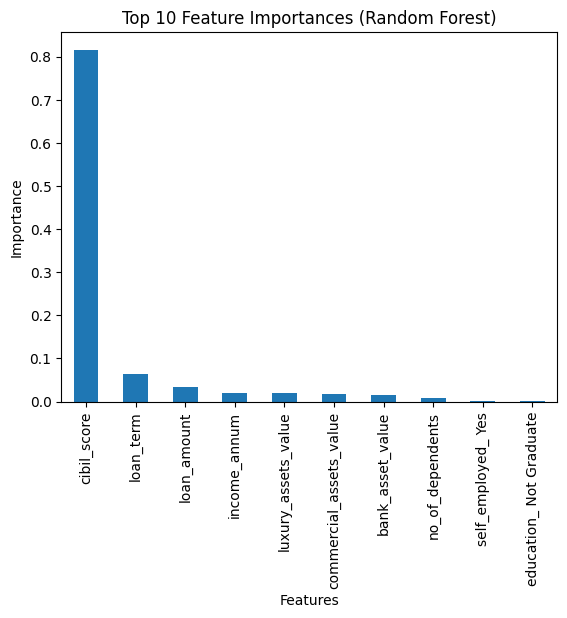

In [12]:
importances = rf.feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(10)

plt.figure()
feat_imp.plot(kind='bar')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

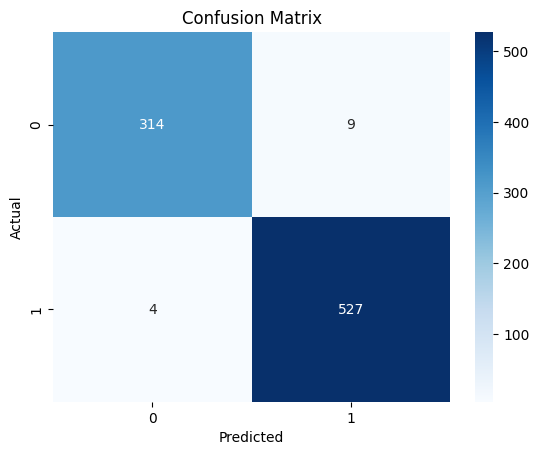

In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

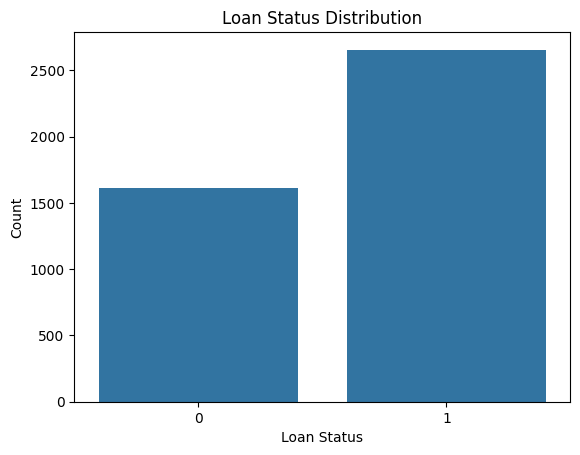

In [19]:
plt.figure()
sns.countplot(x='loan_status', data=data)
plt.title("Loan Status Distribution")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

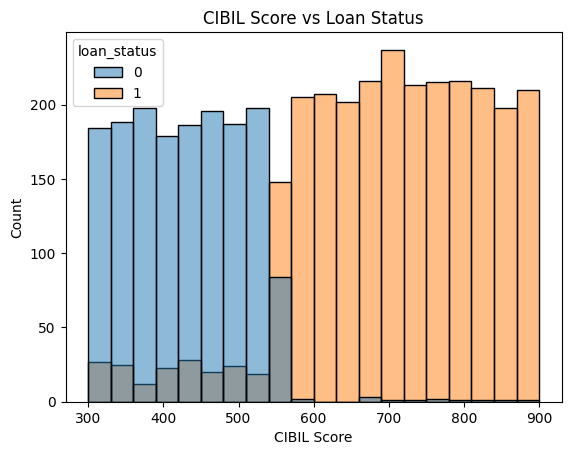

In [20]:
plt.figure()
sns.histplot(data=data, x='cibil_score', hue='loan_status', bins=20, kde=False)
plt.title("CIBIL Score vs Loan Status")
plt.xlabel("CIBIL Score")
plt.ylabel("Count")
plt.show()

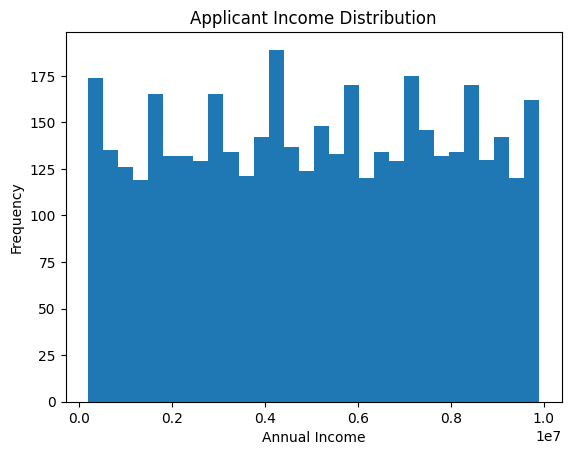

In [21]:
plt.figure()
plt.hist(data['income_annum'], bins=30)
plt.title("Applicant Income Distribution")
plt.xlabel("Annual Income")
plt.ylabel("Frequency")
plt.show()

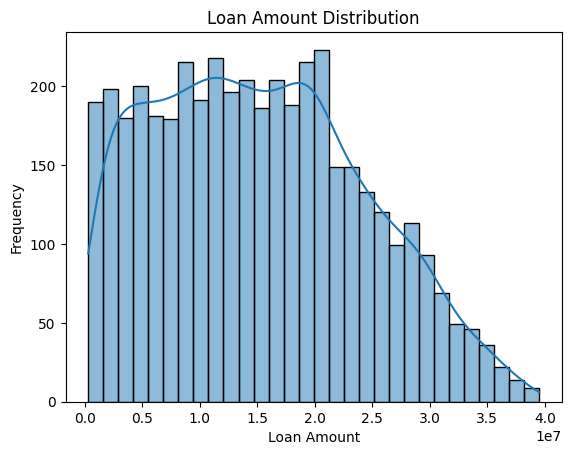

In [22]:
plt.figure()
sns.histplot(data['loan_amount'], bins=30, kde=True)
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.show()